In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import fits
from astropy.io import ascii
from copy import deepcopy

# Observations Definitions

Functions to create at optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def model_info(source, filt, dist):
    
    model_dir = '/Volumes/NIRData/RDong/'
    fname = 'hd142527_hband.fits'
    
    # Model wavelength
    bp = S.ObsBandpass('h')
    w0 = bp.avgwave() / 1e4

    # Model pixels scale
    model_scale = 0.0091
    
    units = 'mJy/arcsec^2'
    
    # File name, arcsec/pix, dist (pc), wavelength (um), flux units
    args_model = (model_dir+fname, model_scale, dist, w0, units)

    return args_model

In [5]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, disk_mod=True, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    if sp_ref is None:
        sp_ref = sp_sci
    
    fov_pix_orig = fov_pix

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        if verbose: print(filt, mask, pupil)

        # Disk Model
        if disk_mod:
            # Convert to photons/sec in specified filter
            args_disk = model_info(sp_sci.name, filt, dist)
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)
            data = hdu_disk[0].data
            data -= np.median(data)
            data[data<0] = 0
            data *= 3 # Input model is from a polarized intensity image
            
            # Mask out some regions
            rho = nrc_utils.dist_image(data, center=(258,244))
            data[rho>163] = 0
            rho = nrc_utils.dist_image(data, center=(260,234))
            data[rho<60] = 0
        else:
            hdu_disk = None
        
        # Create identification keys
        key = make_key(filt, mask=mask, pupil=pupil)
        
        # Define the subarray readout size
        # Set the PSF size and oversampling amount
        if fov_pix is None:
            if mask is None:
                fov_pix = subsize = 400
            elif ('MASK210R' in mask) or ('MASKSWB' in mask):
                fov_pix = subsize = 640
            else:
                fov_pix = subsize = 320
        else:
            subsize = fov_pix
            
        module = 'B' if mask is None else 'A'
            
        #fov_pix = subsize = 320 if fov_pix is None else fov_pix
        oversample = 2

        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_coronagraphy(sp_sci, sp_ref, dist, module=module,
                                               disk_hdu=hdu_disk, wfe_drift=wfe_drift,
                                               filter=filt, mask=mask, pupil=pupil, 
                                               oversample=oversample, fov_pix=fov_pix,
                                               wind_mode='WINDOW', xpix=subsize, ypix=subsize,
                                               verbose=verbose)
        fov_pix = fov_pix_orig
        
    return obs_dict

## Plotting contrasts and planet magnitudes

Functions to plot simulated images and contrast curves

In [6]:
def plot_contrasts(curves, wfe_list, ax=None, colors=None, return_ax=False):
    """Plot a series of contrast curves for corresponding WFE drifts."""
    if ax is None:
        fig, ax = plt.subplots()
    if colors is None:
        lin_vals = np.linspace(0.2,0.7,len(wfe_list))
        colors = plt.cm.Blues_r(lin_vals)[::-1]
    for j, wfe_drift in enumerate(wfe_list):
        rr, contrast, mag_sens = curves[j]
        label="WFE Drift = {} nm".format(wfe_list[j])
        ax.plot(rr, mag_sens, label=label, color=colors[j], zorder=1, lw=2)
        
    if return_ax: return ax


def planet_mags(obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Determine series of exoplanet magnitudes for given observation."""

    pmag = {}
    for i,m in enumerate(mass_list):
        flux_list = []
        for j,av in enumerate(av_vals):
            sp = obs.planet_spec(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s')
            sp_obs = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
            flux = sp_obs.effstim('vegamag')
            flux_list.append(flux)
        pmag[m] = tuple(flux_list)
        
    return pmag

        
def plot_planet_patches(ax, obs, age=10, entropy=13, mass_list=[10,5,2,1], av_vals=[0,25]):
    """Plot exoplanet magnitudes in region corresponding to extinction values."""
    
    xlim = ax.get_xlim()
    cols = plt.cm.tab10(np.linspace(0,1,10))
    
    dist = obs.distance
    
    if entropy<8: entropy=8
    if entropy>13: entropy=13

    pmag = planet_mags(obs, age, entropy, mass_list, av_vals)
    for i,m in enumerate(mass_list):
        pm_min, pm_max = pmag[m]
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pm_min), xlim[1], pm_max-pm_min, alpha=0.2,
                                 color=cols[i], label=label, zorder=2)
        ax.add_patch(rect)
        ax.plot(xlim, [pm_min]*2, color=cols[i], lw=1, alpha=0.3)
        ax.plot(xlim, [pm_max]*2, color=cols[i], lw=1, alpha=0.3)
        

    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, "Warm")
    ent_str = entropy_string + ' Start'
    #ent_str = '{} Start'.format(entropy_string)

    av_str = '$A_V = [{:.0f},{:.0f}]$'.format(av_vals[0],av_vals[1])
    age_str = 'Age = {:.0f} Myr; '.format(age)
    dist_str = 'Dist = {:.1f} pc; '.format(dist) if dist is not None else ''
    #dist_str=""

    ax.set_title('{} -- {} ({}{}{})'.format(obs.filter,ent_str,age_str,dist_str,av_str))


In [7]:
def plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=10, show_sat=False, save_fig=False, **kwargs):
    nfilt = len(filt_keys)
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($r^2$ scale)']
    nim = len(ext_name)

    fig, axes = plt.subplots(nim, nfilt, figsize=(10,8))
    axes = axes.transpose()
    for j, k in enumerate(filt_keys):
        obs = obs_dict[k]
        hdu_mod = obs.disk_hdulist
        hdu_sim = hdu_dict[k]

        # Make r^2 scaled version of data
        hdu_sim_r2 = deepcopy(hdu_sim)
        data  = hdu_sim_r2[0].data
        header = hdu_sim_r2[0].header
        rho = nrc_utils.dist_image(data, pixscale=header['PIXELSCL'])
        data *= rho**2

        # Max value for model
        data_mod   = hdu_mod[0].data
        header_mod = hdu_mod[0].header
        rho_mod    = nrc_utils.dist_image(data_mod, pixscale=header_mod['PIXELSCL'])
        data_mod_r2 = data_mod*rho_mod**2
        vmax  = np.max(data_mod)
        vmax2 = np.max(data_mod_r2)
        
        # Scale value for data
        mask_good = data_mod>(0.5*vmax)
        scl1 = np.median(hdu_sim[0].data[mask_good] / data_mod[mask_good])
        
        # Scale value for r^2 version
        mask_good = data_mod_r2>(0.5*vmax2)
        scl2 = np.median(hdu_sim_r2[0].data[mask_good] / data_mod_r2[mask_good])
        
        #Saturation mask
        if show_sat:
            sat_level = obs.saturation_levels(**kwargs)
            sat_mask = sat_level < 0.8
            # Expand the saturation mask by 1 pixel in 
            for dx in [-1,1]: sat_mask = sat_mask & nrc_utils.fshift(sat_mask, dx, 0)
            for dy in [-1,1]: sat_mask = sat_mask & nrc_utils.fshift(sat_mask, 0, dy)
            im_sat = np.ma.masked_where(sat_mask==1, sat_mask)

        vmax_vals = [vmax,vmax*scl1,vmax2*scl2]
        hdus = [hdu_mod, hdu_sim, hdu_sim_r2]
        for i, ax in enumerate(axes[j]):
            hdulist = hdus[i]
            data = hdulist[0].data
            header = hdulist[0].header

            pixscale = header['PIXELSCL']
            rho = nrc_utils.dist_image(data, pixscale=pixscale)

            rad = data.shape[0] * pixscale / 2
            extent = [-rad, rad, -rad, rad]

            ax.imshow(data, vmin=0, vmax=0.9*vmax_vals[i], extent=extent)
            if (i>0) and show_sat: 
                ax.imshow(im_sat, cmap='autumn', alpha=0.75, extent=extent)

            ax.set_aspect('equal')
            if j > 0: ax.set_yticklabels([])
            if i < nim-1: ax.set_xticklabels([])
            if i==nim-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_ylabel(ext_name[i])

            if i==0: ax.set_title(obs.filter)

            if fov>2*rad:
                xlim = [-rad,rad]
                ylim = [-rad,rad]
            else:
                xlim = [-fov/2,fov/2]
                ylim = [-fov/2,fov/2]
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

            ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
            ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

            ax.tick_params(axis='both', color='white', which='both')
            for k in ax.spines.keys():
                ax.spines[k].set_color('white')

            
    texp = obs_dict[filt_keys[-1]].multiaccum_times['t_exp']
    if obs.mask is not None:
        texp = round(2*texp/100)*100
    else:
        texp = round(texp/100)*100
    exp_text = "t_exp = {:.0f} sec".format(texp)
    wfe_text = "WFE Drift = {} nm".format(wfe_drift)
    fig.suptitle('{} ({}; {})'.format(name_sci, exp_text, wfe_text), fontsize=16);
    fig.tight_layout()

    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, bottom=0.07 , left=0.05, right=0.97)
    
    fname = "{}_images.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

## Functions to init, optimize, and plot

In [8]:
# Generate initial observations for each filter(no WFE drift)
def do_init(disk_mod=True, fov_pix=None, verbose=True):
    wfe_drift = 0
    obs_dict = obs_wfe(wfe_drift, args_list, sp_sci, dist_sci, sp_ref=sp_ref, 
                       disk_mod=disk_mod, fov_pix=fov_pix, verbose=verbose)
    return obs_dict

In [9]:
# Optimize observations
def do_opt(tacq_max, **kwargs):
    sp_opt = pynrc.stellar_spectrum('flat', 20, 'vegamag', bp_k)
    obs_optimize(obs_dict, sp_opt=sp_opt, tacq_max=tacq_max, **kwargs)

In [10]:
# For each filter setting, generate a series of contrast curves at different WFE values
def do_contrast(wfe_list, filt_keys, nsig=5, roll_angle=None, exclude_disk=True):
    contrast_all = {}
    for i, key in enumerate(filt_keys):
        print(key)
        obs = obs_dict[key]

        filt, mask, pupil = args_list[i]
        if roll_angle is None:
            roll_angle = 0 if mask is None else 10

        # Stores tuple of (Radial Distances, Contrast, and Sensitivity) for each WFE drift
        curves = []
        for wfe_drift in wfe_list:
            obs.wfe_drift = wfe_drift
            result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, exclude_disk=exclude_disk)
            curves.append(result)

        contrast_all[key] = curves
    return contrast_all

In [11]:
def do_plot_contrast(obs, curves, wfe_list, nsig, age, xlim=[0,10], ylim=[24,8], save_fig=False):

    fig, axes = plt.subplots(1,2, figsize=(13,4.5))
    entropy_vals = [13,8]

    for j, ax in enumerate(axes.flatten()):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plot_contrasts(curves, wfe_list, ax=ax)
        plot_planet_patches(ax, obs, age=age, entropy=entropy_vals[j])

    for ax in axes.flatten():
        ax.set_xlabel('Distance (arcsec)')
        ax.set_ylabel('{}-sigma Sensitivities (mag)'.format(nsig))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(ncol=2)

    fig.tight_layout()
    
    t_exp = obs.multiaccum_times['t_exp']
    t_exp = round(2*t_exp/100)*100
    fig.suptitle('{} (t_exp = {:.0f} sec)'.format(name_sci, t_exp), fontsize=16);
    #fig.subplots_adjust(top=0.85)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)

    fname = "{}_contrast.pdf".format(name_sci.replace(" ", ""))
    if save_fig: 
        fig.savefig(outdir+fname)

In [12]:
def do_gen_hdus(obs_dict, wfe_drift, verbose=False, **kwargs):
    
    """
    kwargs to pass to gen_roll_image() and their defaults:
    
    PA1 = 0
    PA2 = 10
    zfact         = None
    oversample    = None
    exclude_disk  = False
    exclude_noise = False
    opt_diff      = True
    """
    
    hdulist_dict = {}
    for key in filt_keys:
        if verbose: print(key)
        obs = obs_dict[key]
        obs.wfe_drift = wfe_drift
        hdulist = obs.gen_roll_image(**kwargs)
        
        hdulist_dict[key] = hdulist
        
    return hdulist_dict

# Define Sources and their Reference Counterparts

In [13]:
# K-Band Filter
# 2MASS Bandpass
tbl = ascii.read("2mass_ks.txt", names=['Wave', 'Throughput'])
bp_k = S.ArrayBandpass(tbl['Wave']*1e4, tbl['Throughput'], name='Ks')

outdir  = '/Volumes/NIRData/'

In [14]:
#                source,     dist, age, sptype, kmag
args_sources = [('HD142527', 140, 1.0, 'F5V', 5.2)]

# Corresponding reference stars
ref_sources =  [('HD145158', 'F6V', 5.47)]

In [15]:
i=0

name_sci, dist_sci, age, spt_sci, kmag_sci = args_sources[i]
name_ref, spt_ref, kmag_ref = ref_sources[i]

# Science target and reference star spectra
sp_sci = pynrc.stellar_spectrum(spt_sci, kmag_sci, 'vegamag', bp_k, catname='bosz')
sp_ref = pynrc.stellar_spectrum(spt_ref, kmag_ref, 'vegamag', bp_k, catname='bosz')
sp_sci.name = name_sci
sp_ref.name = name_ref

## Direct Imaging

In [16]:
# List of filters
args_list = [('F187N', 'MASK210R', 'CIRCLYOT'),
             ('F210M', 'MASK210R', 'CIRCLYOT'),
             ('F356W', 'MASK430R', 'CIRCLYOT'),
             ('F444W', 'MASK430R', 'CIRCLYOT')]

args_list = [('F187N', None, None),
             ('F210M', None, None),
             ('F405N', None, None),
             ('F444W', None, None)]



filt_keys = []
for filt,mask,pupil in args_list:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [17]:
# Create the four individual observations
obs_dict = do_init(disk_mod=True, fov_pix=None, verbose=True)

F187N None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F210M None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F405N None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.
F444W None None
Generating list of PSFs...
Creating NIRCam reference class...
Finished.


In [18]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]
    
    if 'N' in obs.filter:
        pattern, ng, nint_sci, nint_ref = ('RAPID', 10, 200, 200)
    else:
        pattern, ng, nint_sci, nint_ref = ('RAPID', 5, 400, 400)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(obs.multiaccum_times)

{u't_exp': 3312.48, u't_acq': 3647.8480000000004, u't_int_tot': 18.239240000000002, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 16.5624}
{u't_exp': 3312.48, u't_acq': 3983.2159999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}
{u't_exp': 3312.48, u't_acq': 3647.8480000000004, u't_int_tot': 18.239240000000002, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 16.5624}
{u't_exp': 3312.48, u't_acq': 3983.2159999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}


In [19]:
#for key in filt_keys:
#    obs = obs_dict[key]
#
#    if 'none' in key:
#        pattern, ng, nint_sci, nint_ref = ('RAPID',5,350,350)
#    elif ('MASK210R' in key) or ('MASKSWB' in key):
#        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,4,4)
#    else:
#        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)
#        
#    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
#    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)

In [33]:
# Add 2 planets at PA=0 and PA=90
for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(0.5,0), runits='arcsec')
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(0.5,90), runits='arcsec')
    obs.add_planet(mass=1, age=age, entropy=13, rtheta=(3,45), runits='arcsec')
    obs.add_planet(mass=2, age=age, entropy=13, rtheta=(3,135), runits='arcsec')
    obs.add_planet(mass=5, age=age, entropy=13, rtheta=(3,225), runits='arcsec')
    obs.add_planet(mass=10, age=age, entropy=13, rtheta=(3,315), runits='arcsec')
    obs.add_planet(sptype='M9V', rtheta=(0.09,90), runits='arcsec', renorm_args=(9.9, 'vegamag', bp_k))

In [34]:
#for key in filt_keys:
#    obs = obs_dict[key]
#    im_pl = obs.gen_planets_image()
#    im_disk = obs.gen_disk_image()
#    print(key, im_pl.max(), im_disk.max(), obs.bg_zodi())

In [35]:
wfe_drift = 5
hdu_dict = do_gen_hdus(obs_dict, wfe_drift, verbose=True, opt_diff=False, PA2=0)

F187N_none_none
F210M_none_none
F405N_none_none
F444W_none_none


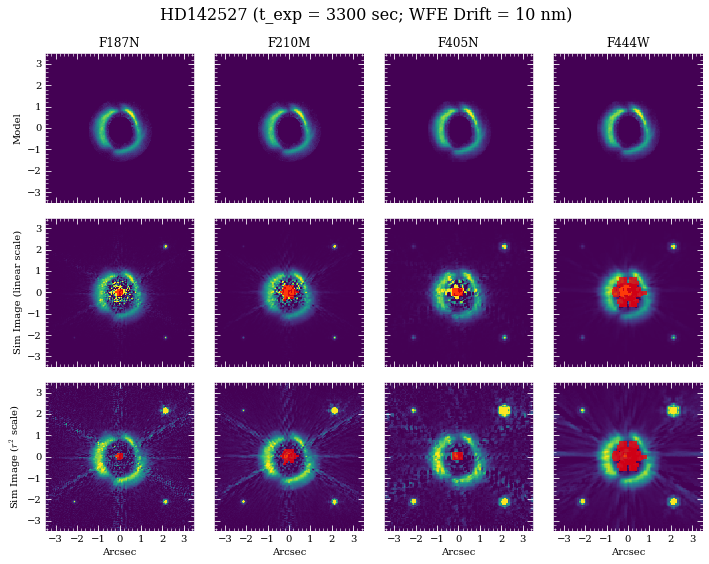

In [38]:
plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=7, save_fig=False, show_sat=True, ngroup=2)

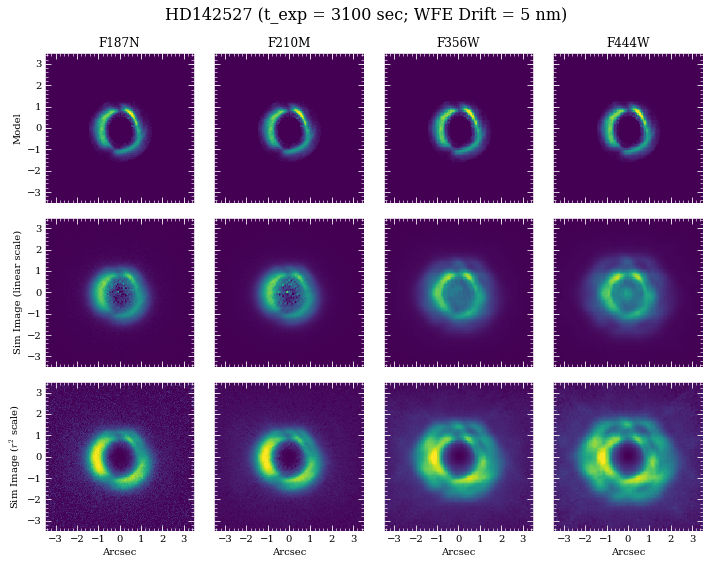

In [25]:
plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=7, save_fig=False)#, show_sat=True, ngroup=1)

### Saturation radius

In [39]:
i1 = 1
i2 = -1

obs1 = obs_dict[filt_keys[i1]]
obs2 = obs_dict[filt_keys[i2]]

In [40]:
print(obs1.multiaccum_times)
print(obs2.multiaccum_times)

{u't_exp': 3312.48, u't_acq': 3983.2159999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}
{u't_exp': 3312.48, u't_acq': 3983.2159999999994, u't_int_tot': 9.958039999999999, u't_frame': 1.65624, u't_group': 1.65624, u't_int': 8.2812}


In [41]:
# Determine saturation that isn't easily interpolated
# F356W
nsat_list = []
rmax_list = []
for sp in [sp_sci, sp_ref]:
    sat_level = obs1.saturation_levels(sp, ngroup=2)
    #print(sat_level.max())
    sat_mask = sat_level > 0.8
    rho = nrc_utils.dist_image(sat_level) # Pixel distances
    
    # How many saturated values can we easily fix?
    sat_level[sat_mask] = np.nan
    sat_level = nrc_utils.fix_nans_with_med(sat_level, niter_max=2)
    
    # Set any NaNs to 1.0
    nan_mask = np.isnan(sat_level)
    sat_level[nan_mask] = 1
    sat_mask = sat_level > 0.8
    
    # Get final info about saturation levels
    nsat = np.size(rho[sat_mask])    
    rval = rho[sat_mask].max() if nsat>0 else 0
    nsat_list.append(nsat)
    rmax_list.append(rval*obs1.pix_scale)

nsat1 = np.max(nsat_list)
rmax1 = np.max(rmax_list)

44 NaNs left after 2 iterations.
44 NaNs left after 2 iterations.


In [42]:
# Determine saturation that isn't easily interpolated
# F444W
nsat_list = []
rmax_list = []
for sp in [sp_sci, sp_ref]:
    sat_level = obs2.saturation_levels(sp, ngroup=2)
    #print(sat_level.max())
    sat_mask = sat_level > 0.8
    rho = nrc_utils.dist_image(sat_level) # Pixel distances
    
    # How many saturated values can we easily fix?
    sat_level[sat_mask] = np.nan
    sat_level = nrc_utils.fix_nans_with_med(sat_level, niter_max=2)
    
    # Set any NaNs to 1.0
    nan_mask = np.isnan(sat_level)
    sat_level[nan_mask] = 1
    sat_mask = sat_level > 0.8
    
    # Get final info about saturation levels
    nsat = np.size(rho[sat_mask])    
    rval = rho[sat_mask].max() if nsat>0 else 0
    nsat_list.append(nsat)
    rmax_list.append(rval*obs2.pix_scale)

nsat2 = np.max(nsat_list)
rmax2 = np.max(rmax_list)

36 NaNs left after 2 iterations.
36 NaNs left after 2 iterations.


In [43]:
print(nsat1, rmax1)
print(nsat2, rmax2)

44 0.133766157903
36 0.239896852835


### Contrast curves

In [44]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,5,10]
nsig = 5
roll = 10
curves_dict = do_contrast(wfe_list, filt_keys, nsig=nsig, roll_angle=roll)

F187N_none_none
F210M_none_none
F405N_none_none
F444W_none_none


In [220]:
def sp_accr(mmdot, rin=2, dist=10, truncated=False):
    
    """
    mmdot : Product of the exoplanet mass and mass accretion rate (MJup^2/yr)
            Values range from 1e-7 to 1e-2.
    rin   : disk inner radius in terms of R_Jup (values)
            Values rnage from 1 to 4.
    dist  : Distance to object (pc)
    
    truncated : If True, then the values are for a disk with Rout=50 RJup,
                otherwise, values were calculated for a full disk (Rout=1000 RJup).
                Accretion from a "tuncated disk" is due mainly to MRI.
                Luminosities for full and truncated disks are very similar.
    """
        
    base_dir = conf.PYNRC_PATH + 'spiegel/'
    fname = base_dir + 'zhu15_accr.txt'

    names = ('MMdot', 'Rin', 'Tmax', 'J', 'H', 'K', 'L', 'M', 'N', 'J2', 'H2', 'K2', 'L2', 'M2', 'N2')
    tbl = ascii.read(fname, guess=True, names=names)

    # Inner radius values and Mdot values
    rin_vals = np.unique(tbl['Rin'])
    mdot_vals = np.unique(tbl['MMdot'])

    assert (rin >=rin_vals.min())  & (rin <=rin_vals.max())
    assert (mmdot>=mdot_vals.min()) & (mmdot<=mdot_vals.max())

    if truncated:
        mag_names = ('J2', 'H2', 'K2', 'L2', 'M2', 'N2')
    else:
        mag_names = ('J', 'H', 'K', 'L', 'M', 'N')
    wcen = np.array([ 1.2,  1.6, 2.2, 3.8, 4.8, 10.0])
    zpt  = np.array([1600, 1020, 657, 252, 163, 39.8])
        
    mag_arr = np.zeros([6,nm])        
    for i, mv in enumerate(mdot_vals):
        for j, mag in enumerate(mag_names):
            tbl_sub = tbl[tbl['MMdot']==mv]
            rinvals = tbl_sub['Rin']
            magvals = tbl_sub[mag]

            mag_arr[j,i] = np.interp(rin, rinvals, magvals)

    mag_vals = np.zeros(6)
    for j in range(6):
        xi = 10**(mmdot)
        xp = 10**(mdot_vals)
        yp = 10**(mag_arr[j])
        mag_vals[j] = np.log10(np.interp(xi, xp, yp))
        
    mag_vals += 5*np.log10(dist/10)
    flux_Jy = 10**(-mag_vals/2.5) * zpt
        
    return wcen, flux_Jy
    
    


In [225]:
w, f = sp_accr(1e-2,1,100)
#m2 = m + 5*np.log10(100/10)

print(w,f)

sp = S.ArraySpectrum(w*1e4, f, fluxunits='Jy')
sp.convert('flam')

[  1.2   1.6   2.2   3.8   4.8  10. ] [ 1.9236231   1.61659106  1.37266756  1.3225148   1.35577495  1.20194078]


In [226]:
sp.flux

array([  4.00477567e-13,   1.89313206e-13,   8.50238391e-14,
         2.74570611e-14,   1.76411069e-14,   3.60332782e-15])

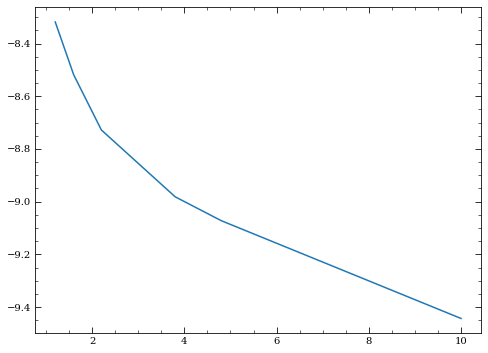

In [227]:
plt.plot(sp.wave/1e4, np.log10(sp.flux*sp.wave))

In [167]:
rin = 4
truncated=False

base_dir = pynrc.conf.PYNRC_PATH + 'spiegel/'
fname = base_dir + 'zhu15_accr.txt'

names = ('Mdot', 'Rin', 'Tmax', 'J', 'H', 'K', 'L', 'M', 'N', 'J2', 'H2', 'K2', 'L2', 'M2', 'N2')
tbl = ascii.read(fname, guess=True, names=names)

# Inner radius values and Mdot values
rin_vals = np.unique(tbl['Rin'])
mdot_vals = np.unique(tbl['Mdot'])

mag_arr = np.zeros([6,nm])
if truncated:
    mag_names = ('J2', 'H2', 'K2', 'L2', 'M2', 'N2')
else:
    mag_names = ('J', 'H', 'K', 'L', 'M', 'N')
for i, mdot in enumerate(mdot_vals):
    for j, mag in enumerate(mag_names):
        tbl_sub = tbl[tbl['Mdot']==mdot]
        rinvals = tbl_sub['Rin']
        magvals = tbl_sub[mag]

        mag_arr[j,i] = np.interp(rin, rinvals, magvals)
        
mdot = 5e-3
mag_vals = np.zeros(6)
for j in range(6):
    xi = 10**(mdot)
    xp = 10**(mdot_vals)
    yp = 10**(mag_arr[j])
    print(mag_arr[j])
    mag_vals[j] = np.log10(np.interp(xi, xp, yp))

[ 58.   44.8  38.1  33.8  26.2  22.4  20.4  15.6  13.2  11.5   5.4   2.9]
[ 45.   35.   29.9  26.6  20.8  18.   16.4  12.7  10.8   9.6   5.2   2.4]
[ 35.   27.3  23.4  20.9  16.5  14.4  13.2  10.2   8.7   7.8   4.5   2. ]
[ 22.1  17.6  15.3  13.8  11.1   9.8   9.1   6.9   6.    5.3   3.1   1.1]
[ 18.6  14.8  12.9  11.7   9.5   8.5   7.7   5.9   5.2   4.6   2.6   0.7]
[ 10.9   9.1   8.1   7.4   6.2   5.5   5.    4.    3.4   3.    1.1  -0.8]


In [166]:
mag_vals

array([ 5.14780812,  4.94726675,  4.24780812,  2.85014712,  2.35102955,
        0.85102955])

In [133]:
rin_vals = np.unique(tbl['Rin'])
mdot_vals = np.unique(tbl['Mdot'])

nr =  len(rin_vals)
nm = len(mdot_vals)

mag_vals = np.zeros([6, nm, nr])
if truncated:
    mag_names = ('J2', 'H2', 'K2', 'L2', 'M2', 'N2')
else:
    mag_names = ('J', 'H', 'K', 'L', 'M', 'N')
for i, rin in enumerate(rin_vals):
    tbl_sub = tbl[tbl['Rin']==rin]
    tbl_sub2 = tbl_sub[('J', 'H', 'K', 'L', 'M', 'N')]
    for j in range(nm):
        row = tbl_sub2[j]
        mag_vals[:,j,i] = np.asarray(tuple(row))
#    tbl_sub.
    #print(tbl_sub.as_array().shape)
#mag_vals[:]
#mag_vals.shape

#tmax_vals = np.unique(tbl['Mdot'])

#tbl_sub = tbl[((tbl['Rin']==4) & (tbl['Mdot']==0.01))]
#plt.loglog(tbl_sub['Mdot'], tbl_sub['L2'])

In [154]:
plt.plot(mdot_vals, mag_vals[3,:,3])

IndexError: too many indices for array

In [86]:
tbl_sub

Mdot,Rin,Tmax,J,H,K,L,M,N,J2,H2,K2,L2,M2,N2
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.01,4.0,4434,2.9,2.4,2.0,1.1,0.7,-0.8,2.9,2.4,2.0,1.1,0.7,-0.3


In [45]:
curves1 = curves_dict[filt_keys[i1]]
curves2 = curves_dict[filt_keys[i2]]

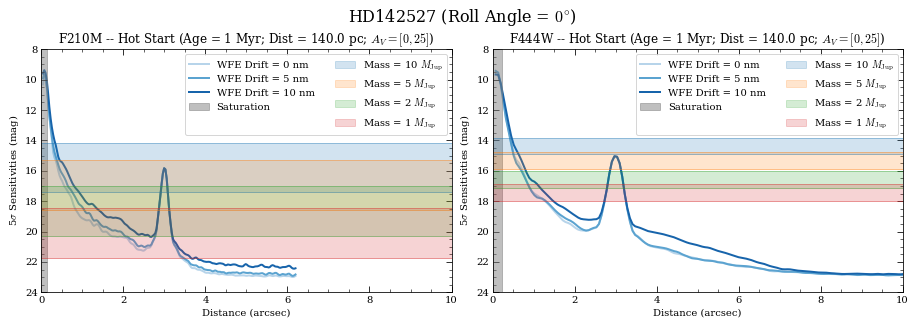

In [46]:
# Plot the contrast curves along with saturation regions
xlim=[0,10]
ylim=[24,8]

fig, axes = plt.subplots(1,2, figsize=(13,4.5))
ax1, ax2 = axes
entropy_vals = [13,8]

for j, ax in enumerate(axes):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

label = 'Saturation'
if rmax1>0:
    rect1 = patches.Rectangle((0,ylim[0]), rmax1, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax1.add_patch(rect1)
if rmax2>0:
    rect2 = patches.Rectangle((0,ylim[0]), rmax2, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax2.add_patch(rect2)
    
plot_contrasts(curves1, wfe_list, ax=ax1)
plot_contrasts(curves2, wfe_list, ax=ax2)
plot_planet_patches(ax1, obs1, age=age, entropy=13, av_vals=[0,25])
plot_planet_patches(ax2, obs2, age=age, entropy=13, av_vals=[0,25])


for ax in axes.flatten():
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}$\sigma$ Sensitivities (mag)'.format(nsig))
    ax.legend(ncol=2)
    
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

fig.tight_layout()

roll_val = 0 if 'none' in filt_keys[0] else 10
rstr = '{:.0f}'.format(roll_val)
roll_str = "$"+rstr+"^{\circ}$"
fig.suptitle('{} (Roll Angle = {})'.format(name_sci,roll_str), fontsize=16);
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)


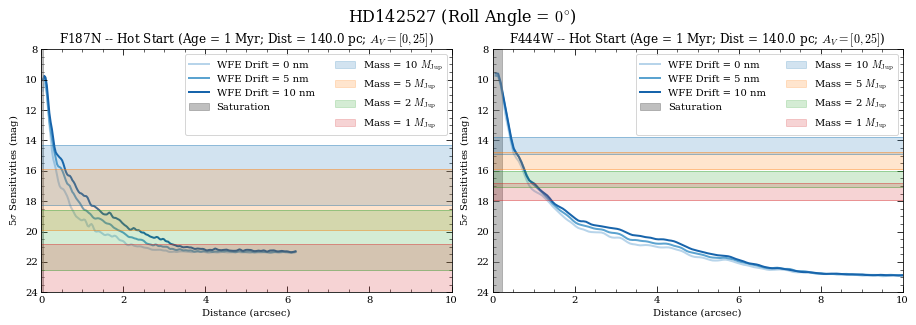

In [29]:
# Plot the contrast curves along with saturation regions
xlim=[0,10]
ylim=[24,8]

fig, axes = plt.subplots(1,2, figsize=(13,4.5))
ax1, ax2 = axes
entropy_vals = [13,8]

for j, ax in enumerate(axes):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

label = 'Saturation'
if rmax1>0:
    rect1 = patches.Rectangle((0,ylim[0]), rmax1, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax1.add_patch(rect1)
if rmax2>0:
    rect2 = patches.Rectangle((0,ylim[0]), rmax2, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax2.add_patch(rect2)
    
plot_contrasts(curves1, wfe_list, ax=ax1)
plot_contrasts(curves2, wfe_list, ax=ax2)
plot_planet_patches(ax1, obs1, age=age, entropy=13, av_vals=[0,25])
plot_planet_patches(ax2, obs2, age=age, entropy=13, av_vals=[0,25])


for ax in axes.flatten():
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}$\sigma$ Sensitivities (mag)'.format(nsig))
    ax.legend(ncol=2)
    
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

fig.tight_layout()

roll_str = r"$0^{\circ}$"
fig.suptitle('{} (Roll Angle = {})'.format(name_sci,roll_str), fontsize=16);
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)


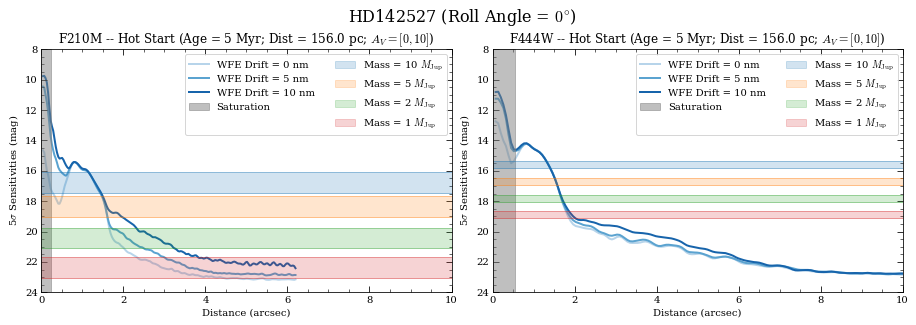

In [39]:
# Plot the contrast curves along with saturation regions
xlim=[0,10]
ylim=[24,8]

fig, axes = plt.subplots(1,2, figsize=(13,4.5))
ax1, ax2 = axes
entropy_vals = [13,8]

for j, ax in enumerate(axes):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

label = 'Saturation'
if rmax1>0:
    rect1 = patches.Rectangle((0,ylim[0]), rmax1, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax1.add_patch(rect1)
if rmax2>0:
    rect2 = patches.Rectangle((0,ylim[0]), rmax2, ylim[1]-ylim[0], alpha=0.5,
                              color='grey', label=label, zorder=2)
    ax2.add_patch(rect2)
    
plot_contrasts(curves1, wfe_list, ax=ax1)
plot_contrasts(curves2, wfe_list, ax=ax2)
plot_planet_patches(ax1, obs1, age=age, entropy=13, av_vals=[0,10])
plot_planet_patches(ax2, obs2, age=age, entropy=13, av_vals=[0,10])


for ax in axes.flatten():
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}$\sigma$ Sensitivities (mag)'.format(nsig))
    ax.legend(ncol=2)
    
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

fig.tight_layout()

roll_str = r"$0^{\circ}$"
fig.suptitle('{} (Roll Angle = {})'.format(name_sci,roll_str), fontsize=16);
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)


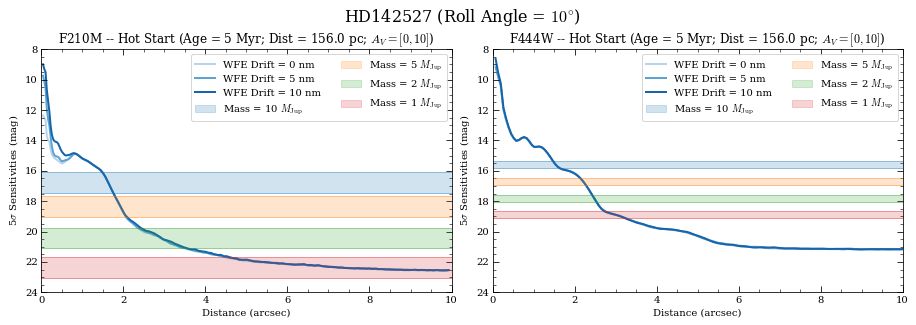

In [150]:
# Plot the contrast curves along with saturation regions
xlim=[0,10]
ylim=[24,8]

fig, axes = plt.subplots(1,2, figsize=(13,4.5))
ax1, ax2 = axes
entropy_vals = [13,8]

for j, ax in enumerate(axes):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plot_contrasts(curves1, wfe_list, ax=ax1)
plot_contrasts(curves2, wfe_list, ax=ax2)
plot_planet_patches(ax1, obs1, age=age, entropy=13, av_vals=[0,10])
plot_planet_patches(ax2, obs2, age=age, entropy=13, av_vals=[0,10])

#label = 'Saturation'
#if rmax1>0:
#    rect1 = patches.Rectangle((0,ylim[0]), rmax1, ylim[1]-ylim[0], alpha=0.5,
#                              color='grey', label=label, zorder=2)
#    ax1.add_patch(rect1)
#if rmax2>0:
#    rect2 = patches.Rectangle((0,ylim[0]), rmax2, ylim[1]-ylim[0], alpha=0.5,
#                              color='grey', label=label, zorder=2)
#    ax2.add_patch(rect2)


for ax in axes.flatten():
    ax.set_xlabel('Distance (arcsec)')
    ax.set_ylabel('{}$\sigma$ Sensitivities (mag)'.format(nsig))
    ax.legend(ncol=2)
    
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

fig.tight_layout()

roll_str = r"$10^{\circ}$"
fig.suptitle('{} (Roll Angle = {})'.format(name_sci,roll_str), fontsize=16);
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.85, bottom=0.1 , left=0.05, right=0.97)


## Full observation simulations

In [37]:
for k in filt_keys:
    obs = obs_dict[k]
    obs.wfe_drift = 5

In [38]:
# Select F444W with two rolls at PA of 250 and 260
obs = obs2

roll_angle = 10
PA1 = 250
PA2 = PA1 + roll_angle

xpix = obs.det_info['xpix']
ypix = obs.det_info['ypix']

In [39]:
# Detector ID
det = obs.Detectors[0]
detid = det.detid

In [40]:
# Get mask center from SIAF aperture file
from jwxml import siaf
inst = siaf.SIAF('NIRCam')
apname = 'NRC'
ap = inst['NRCA5_MASK430R']
mask_cen = ap.center('Det')

In [46]:
# Add Fomalhaut b
rtheta = (12.7, 318.0) # 12.7 arcsec radius at PA=318
# Output images will be in coordinates with V3 up and V2 to the left
obs.add_planet(mass=1, age=age, entropy=8, rtheta=rtheta, runits='arcsec')

In [42]:
# Coronagraphic Transmission mask
# +V3 is up, and +V2 is to the left
# Pixel (0,0) is bottom right
cmask = nrc_utils.build_mask('A', pixscale=obs.pix_scale) + 999
cmask = nrc_utils.pad_or_cut_to_size(cmask, (ypix,xpix))

# Place cmask in detector coords
cmask = nrc_utils.V2V3_to_det(cmask, detid)

# Shift cmask to appropriate location
# ie., move MASK430R from center
xc, yc = (xpix/2, ypix/2)
xnew, ynew = (int(mask_cen[0]), int(mask_cen[1])) # In detector coords
delx = xnew - xc
dely = ynew - yc

cmask = nrc_utils.fshift(cmask, delx, dely) + 1
cmask[cmask>10] = cmask[cmask>10] - 1000

cmask[1500:,0:260]=0
cmask[1500:,1900:]=0
cmask[1820:,:] = 0

In [43]:
# Make zodiacal background image
im_zodi = cmask * obs.bg_zodi()

In [44]:
# Disk Images
im_disk1 = obs.gen_disk_image(PA_offset=PA1)
im_disk2 = obs.gen_disk_image(PA_offset=PA2)

if isinstance(im_disk1, np.ndarray):
    # Convert to Detector Coordinates (flip along x-axis)
    im_disk1 = nrc_utils.V2V3_to_det(im_disk1, detid)
    im_disk2 = nrc_utils.V2V3_to_det(im_disk2, detid)

    # Shift to MASK430R spot
    im_disk1 = nrc_utils.fshift(im_disk1, delx, dely, pad=True)
    im_disk2 = nrc_utils.fshift(im_disk2, delx, dely, pad=True)

    # Mask out opaque areas from disk
    imask = cmask<1e-2
    im_disk1[imask] = im_disk1[imask]*cmask[imask]
    im_disk2[imask] = im_disk2[imask]*cmask[imask]

In [47]:
# Planet Images
im_pl1 = obs.gen_planets_image(PA_offset=PA1)
im_pl2 = obs.gen_planets_image(PA_offset=PA2)

if isinstance(im_pl1, np.ndarray):
    # Convert to Detector Coordinates (flip along x-axis)
    im_pl1 = nrc_utils.V2V3_to_det(im_pl1, detid)
    im_pl2 = nrc_utils.V2V3_to_det(im_pl2, detid)

    # Shift to MASK430R spot
    im_pl1 = nrc_utils.fshift(im_pl1, delx, dely, pad=True)
    im_pl2 = nrc_utils.fshift(im_pl2, delx, dely, pad=True)

    # Mask out opaque areas from disk
    imask = cmask<1e-2
    im_pl1[imask] = im_pl1[imask]*cmask[imask]
    im_pl2[imask] = im_pl2[imask]*cmask[imask]

In [48]:
# Create stellar images
im_star = obs.gen_psf(sp_sci)
im_ref  = obs.nrc_ref.gen_psf(sp_ref)

im_star = nrc_utils.pad_or_cut_to_size(im_star, (ypix,xpix))
im_ref  = nrc_utils.pad_or_cut_to_size(im_ref, (ypix,xpix))

# Convert to Detector Coordinates (flip along x-axis)
im_star = nrc_utils.V2V3_to_det(im_star, detid)
im_ref  = nrc_utils.V2V3_to_det(im_ref, detid)

# Shift to MASK430R spot
im_star = nrc_utils.fshift(im_star, delx, dely, pad=True)
im_ref  = nrc_utils.fshift(im_ref, delx, dely, pad=True)

In [49]:
sci_slope1 = im_star + im_disk1 + im_pl1 + im_zodi
sci_slope2 = im_star + im_disk2 + im_pl2 + im_zodi

ref_slope  = im_ref + im_zodi

In [50]:
# Superbias for data reduction
caldir  = pynrc.conf.PYNRC_PATH + 'sca_images/'
fbias = caldir + 'SUPER_BIAS_485.FITS'
hdl = fits.open(fbias)
bias = hdl[0].data

In [51]:
def average_slopes(ramps, bias):
    """
    For a series of ramps, calculate the slope images then average together.
    Would it be better to average integrations into one ramp, then find slope???
    """

    slopes_fin = []
    for i in range(len(ramps)):
        #print(i)
        hdulist = ramps[i]
        data = hdulist[1].data
        header = hdulist[0].header
        ref_obj = pynrc.ref_pixels.NRC_refs(data, header, DMS=True)
        ref_obj.calc_avg_amps()
        ref_obj.correct_amp_refs()

        # Subtract superbias
        data_corr = ref_obj.data
        for im in data_corr:
            im -= bias

        # Create time array
        ng = data_corr.shape[0]
        tvals = (np.arange(ng)+1) * obs.multiaccum_times['t_group']

        # Flatten image space to 1D
        data_corr = data_corr.reshape([ng,-1])

        # Make saturation mask
        sat_val = 0.8*data_corr.max()
        sat_mask = data_corr > sat_val

        # Create slope images
        # Cycle through frames using only unsaturated pixels 
        im_slope = np.zeros_like(data_corr[0]) - 10
        for i in np.arange(1,ng)[::-1]:
            ind = (im_slope==-10) & (~sat_mask[i])
            if np.any(ind): # Check if any pixels are still True
                im_slope[ind] = pynrc.fast_poly.jl_poly_fit(tvals, data_corr[:,ind])[1]
            #print(im_slope[ind].shape)

        # Special case of only first frame unsaturated
        ind = (im_slope==-10) & (~sat_mask[0])
        im_slope[ind] = data_corr[:,ind] / tvals[0]
        #print(im_slope[ind].shape)

        # If saturated on first frame, set to NaN
        ind = sat_mask[0]
        im_slope[ind] = np.nan
        #print(im_slope[ind].shape)

        data_corr = data_corr.reshape([ng,ypix,xpix])
        im_slope = im_slope.reshape([ypix,xpix])
        slopes_fin.append(im_slope)

    slopes_fin = np.array(slopes_fin)
    slope_final = np.nanmedian(slopes_fin, axis=0)
    
    # Fix NaNs
    slope_final = nrc_utils.fix_nans_with_med(slope_final)

    return slope_final

In [52]:
ramps = obs.gen_exposures(im_slope=sci_slope1, targ_name=name_sci)
slope_final1 = average_slopes(ramps, bias)

In [53]:
ramps = obs.gen_exposures(im_slope=sci_slope2, targ_name=name_sci)
slope_final2 = average_slopes(ramps, bias)

In [54]:
ramps = obs.nrc_ref.gen_exposures(im_slope=ref_slope, targ_name=name_ref)
slope_ref = average_slopes(ramps, bias)

In [55]:
med1 = np.median(slope_final1)
med2 = np.median(slope_final2)
med_ref = np.median(slope_ref)

print(med1, med2, med_ref)

0.183592069037 0.187980095803 0.177738883415


In [56]:
half_size = 100
x1, x2 = (xnew-half_size, xnew+half_size)
y1, y2 = (ynew-half_size, ynew+half_size)

ref_sub = slope_ref[y1:y2, x1:x2] - med_ref
im1_sub = slope_final1[y1:y2, x1:x2] - med1
im2_sub = slope_final2[y1:y2, x1:x2] - med2

# Scale factor for Roll 1
scale1 = nrc_utils.scale_ref_image(im1_sub, ref_sub)

# Scale factor for Roll 2
scale2 = nrc_utils.scale_ref_image(im2_sub, ref_sub)

In [57]:
print(scale1, scale2)

0.926398383733 0.926210486289


In [58]:
mask_good = cmask>1e-2
diff1 = nrc_utils.optimal_difference(slope_final1, slope_ref, scale1, mask_good=mask_good,
                                     center=(xnew,ynew))#, std_func=pynrc.robust.medabsdev)
diff2 = nrc_utils.optimal_difference(slope_final2, slope_ref, scale2, mask_good=mask_good,
                                     center=(xnew,ynew))#, std_func=pynrc.robust.medabsdev)

#diff1 = (slope_final1-med1) - (slope_ref-med_ref)*scale1
#diff2 = (slope_final2-med2) - (slope_ref-med_ref)*scale1

In [59]:
from scipy.ndimage.interpolation import rotate
def rotateImage(img, angle, pivot, trim=True):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = rotate(imgP, angle, reshape=False, cval=np.nan)
    if trim: imgR = imgR[padY[0] : -padY[1], padX[0] : -padX[1]]
    
    return imgR

In [60]:
# Convert back to V2/V3 coordinates
diff1_v23 = nrc_utils.det_to_V2V3(diff1, detid)
diff2_v23 = nrc_utils.det_to_V2V3(diff2, detid)
cmask_v23 = nrc_utils.det_to_V2V3(cmask, detid)

# De-rotate Roll2 onto Roll1 
xnew_flip = xpix - xnew
diff2_v23_rot = rotateImage(diff2_v23, roll_angle, (xnew_flip,ynew))
# Follow along with the coronagraphic mask
cmask_v23_rot = rotateImage(cmask_v23, roll_angle, (xnew_flip,ynew))

In [61]:
# Mask areas with low coronagraphic transmission
# Cut-off at 0.5 to exclude aliasing of rotated mask
mask_bad1 = cmask_v23 < 0.5
mask_bad2 = cmask_v23_rot < 0.5

diff2_v23_rot[mask_bad2 & (~mask_bad1)] = diff1_v23[mask_bad2 & (~mask_bad1)]
diff1_v23[mask_bad1 & (~mask_bad2)] = diff2_v23_rot[mask_bad1 & (~mask_bad2)]

In [62]:
# Create a final image
im_final = (diff1_v23 + diff2_v23_rot) / 2
nan_mask = np.isnan(im_final)
im_final[nan_mask] = diff1_v23[nan_mask]

In [63]:
# Shift to center, rotate North up, then cut out a subarray 
im_final_shift = nrc_utils.fshift(im_final, xpix/2-xnew_flip, ypix/2-ynew, pad=True)
im_final_rot = rotate(im_final_shift, PA1, reshape=False)
im_final_rot_sub = nrc_utils.pad_or_cut_to_size(im_final_rot, (800,800))

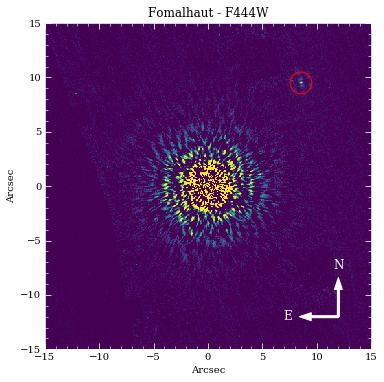

In [64]:
fig, ax = plt.subplots(1,1)

ys, xs = im_final_rot_sub.shape
extent = np.array([-xs/2,xs/2,-ys/2,ys/2])*obs.pix_scale

ax.imshow(im_final_rot_sub, vmin=0, vmax=1, extent=extent)
xylim = 15
ax.set_xlim([-xylim,xylim])
ax.set_ylim([-xylim,xylim])
ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')
ax.set_title('{} - {}'.format(obs.sp_sci.name,obs.filter))

ax.tick_params(axis='both', color='white', which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color('white')

# Location of planet
loc = (np.array(obs.planets[0]['xyoff_pix'])+0.5) * obs.pix_scale
circle = matplotlib.patches.Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
ax.add_artist(circle);

nrc_utils.plotAxes(ax, label1='E', label2='N')